**deepComms**<br>
By $\text{Rishabh Pomaje}$

> Objective

- **Learning a (7, 4) Code system** 
- Under the following conditions
    - BPSK modulation
    - Channel Model - AWGN

In [1]:
# Importing the necessary dependencies :
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf 
%config InlineBackend.figure_format='svg'
print(tf.__version__)
TF_ENABLE_ONEDNN_OPTS = 0

2.16.1


- Using the following definition of SNR :
\begin{equation}
\text{SNR}_{linear} = \frac{E_b}{N_0} = \frac{\text{Tx. Signal Power per bit}}{\text{Noise Variance}}
\end{equation}
- Per bit energies :
- BPSK : {$\pm \sqrt{E_{b}}$}
- $E_{uncoded} = 1$
\begin{equation}
E_{coded} = E_{uncoded} \times k / n = E_{uncoded} \times R
\end{equation}
- $R$ = Information Rate 
- $\color{red}{Note}$ : This difference in energy per bit needs to be compensated in either symbol energy or the noise variance. I have arbitrarily chosen it to be the noise variance.

> System Parameters

In [2]:
# Size of alphabet
M = 2 ** 4        
# Number of bits required                                
k = np.log2(M)    
# Block length of coded vector
n = 7                 
# Communication rate    
R = k / n              

> Generation of training data

In [3]:
# 2^k dimensional One-Hot Encoded vectors will be used
training_data_size = 10 ** 6 # in number of block of k bits
sample_indices = np.random.randint(0, M, training_data_size)

# Set of One Hot Encoded Vectors :
x_train = []
for idx in sample_indices:
    temp = np.zeros(M)
    temp[idx] = 1
    x_train.append(temp)

# Labels for the data :
# Since we want to reproduce the input at the output :
x_train = tf.constant(x_train)
y_train = x_train

> Creating the Auto-Encoder Model 

In [4]:
# Describing the encoder layers :
enc_input_layer = tf.keras.Input(shape=(M,), name='Input Layer')
enc_layer_01 = tf.keras.layers.Dense(M, activation='relu', name='Encoder_Hidden_01')(enc_input_layer)
enc_layer_02 = tf.keras.layers.Dense(n, activation='linear', name='Encoder_Hidden_02')(enc_layer_01)
enc_layer_normalized = tf.keras.layers.Lambda((lambda x: np.sqrt(n) * tf.keras.backend.l2_normalize(x, axis=-1)))(enc_layer_02)

# Describing the channel layers :
# Training SNR
SNR_dB = 7                                       # Eb / N0 in dB scale
SNR_lin = 10 ** (SNR_dB / 10)                    # In linear scale
ch_noise_layer = tf.keras.layers.GaussianNoise(stddev=np.sqrt(1 / (2 * R * SNR_lin)), name='AWGN_channel')(enc_layer_normalized)

# Describing the decoder layers :
dec_layer_01 =  tf.keras.layers.Dense(M, activation='relu', name='Decoder_Hidden_01')(ch_noise_layer)
dec_output_layer = tf.keras.layers.Dense(M, activation='softmax', name='Output_Layer')(dec_layer_01)

autoencoder = tf.keras.Model(enc_input_layer,dec_output_layer)

# Compiling the model :
autoencoder.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss=tf.keras.losses.CategoricalCrossentropy(), metrics=['accuracy'])
autoencoder.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Input Layer (InputLayer)        │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Encoder_Hidden_01 (Dense)       │ (None, 16)             │           272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Encoder_Hidden_02 (Dense)       │ (None, 7)              │           119 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda (Lambda)                 │ (None, 7)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ AWGN_channel (GaussianNoise)    │ (None, 7)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Decoder_Hidden_01 (Dense)       │ (None, 16)             │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Output_Layer (Dense)            │ (None, 16)             │           272 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 791 (3.09 KB)

 Trainable params: 791 (3.09 KB)

 Non-trainable params: 0 (0.00 B)

In [5]:
tf.keras.utils.plot_model(autoencoder, "images/deepComms_7_4.png", show_shapes=True, show_layer_names=True, show_layer_activations=True, dpi=1000)

You must install pydot (`pip install pydot`) for `plot_model` to work.


In [6]:
# Fitting the model by using training set :
autoencoder.fit(x_train, y_train, batch_size=1000, epochs=250) 

Epoch 1/250
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 21s 11ms/step - accuracy: 0.7628 - loss: 1.0576
Epoch 2/250
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 28s 27ms/step - accuracy: 0.9991 - loss: 0.0230
Epoch 3/250
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 34s 34ms/step - accuracy: 0.9992 - loss: 0.0086
Epoch 4/250
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 25s 23ms/step - accuracy: 0.9994 - loss: 0.0049
Epoch 5/250
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 44s 27ms/step - accuracy: 0.9995 - loss: 0.0032
Epoch 6/250
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 25s 24ms/step - accuracy: 0.9995 - loss: 0.0024
Epoch 7/250
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 23s 22ms/step - accuracy: 0.9996 - loss: 0.0018
Epoch 8/250
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 24s 24ms/step - accuracy: 0.9996 - loss: 0.0017
Epoch 9/250
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - accuracy: 0.9996 - loss: 0.0014
Epoch 10/250
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.9997 - loss: 0.0012
Epoch 11/250
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9997 - loss: 0.0011
Epo

> Testing the above learned system
- Creating the individual Encoder/ Decoder Models for use

In [7]:
# Encoder :
encoder_model = tf.keras.Model(enc_input_layer, enc_layer_normalized)

# Supposed received codeword at the receiver
encoded_input = tf.keras.Input(shape=(n,))
decoder_output = autoencoder.layers[-2](encoded_input)
decoder_output = autoencoder.layers[-1](decoder_output)

# Decoder :
decoder_model = tf.keras.Model(encoded_input, decoder_output)

> Generation of validation data

In [8]:
test_data_size = 10 ** 6 # Number of Blocks 
y_test = np.random.randint(0, M, test_data_size)
x_test = []
for idx in y_test:
    temp = np.zeros(M)
    temp[idx] = 1
    x_test.append(temp)

x_test = tf.constant(x_test)

In [9]:
# Range of Signal to Noise Ratio that will be used for validation 
# in dB :
SNR_dB = np.linspace(-4, 8, 25)
# in Linear Scale :
SNR_lin = 10 ** (SNR_dB / 10)
# Fixing energy per bit :
E_b = 1 
# Range of noise variance accordingly :
noise_var = 1 / (2 * R * SNR_lin) # This is the real noise only.

> Validation routine

In [10]:
BLER_learned = []
for noise in noise_var :
    # Encoding using our model :
    encoded_signal = encoder_model.predict(x_test)
    # Generating AWGN samples :
    awgn = np.sqrt(noise) * np.random.normal(0, 1, (test_data_size, n))
    rx_noisy_signal = encoded_signal + awgn
    # Decoding using our model :
    decoded_signal = decoder_model.predict(rx_noisy_signal)
    estimated_vectors = np.argmax(decoded_signal, axis=-1)
    BLER_learned.append(np.sum(estimated_vectors != y_test) / test_data_size)

31250/31250 ━━━━━━━━━━━━━━━━━━━━ 71s 2ms/step
31250/31250 ━━━━━━━━━━━━━━━━━━━━ 69s 2ms/step
31250/31250 ━━━━━━━━━━━━━━━━━━━━ 61s 2ms/step
31250/31250 ━━━━━━━━━━━━━━━━━━━━ 68s 2ms/step
31250/31250 ━━━━━━━━━━━━━━━━━━━━ 71s 2ms/step
31250/31250 ━━━━━━━━━━━━━━━━━━━━ 73s 2ms/step
31250/31250 ━━━━━━━━━━━━━━━━━━━━ 65s 2ms/step
31250/31250 ━━━━━━━━━━━━━━━━━━━━ 98s 3ms/step
31250/31250 ━━━━━━━━━━━━━━━━━━━━ 73s 2ms/step
31250/31250 ━━━━━━━━━━━━━━━━━━━━ 73s 2ms/step
31250/31250 ━━━━━━━━━━━━━━━━━━━━ 67s 2ms/step
31250/31250 ━━━━━━━━━━━━━━━━━━━━ 76s 2ms/step
31250/31250 ━━━━━━━━━━━━━━━━━━━━ 72s 2ms/step
31250/31250 ━━━━━━━━━━━━━━━━━━━━ 26s 828us/step
31250/31250 ━━━━━━━━━━━━━━━━━━━━ 26s 831us/step
31250/31250 ━━━━━━━━━━━━━━━━━━━━ 27s 859us/step
31250/31250 ━━━━━━━━━━━━━━━━━━━━ 44s 1ms/step
31250/31250 ━━━━━━━━━━━━━━━━━━━━ 27s 859us/step
31250/31250 ━━━━━━━━━━━━━━━━━━━━ 25s 808us/step
31250/31250 ━━━━━━━━━━━━━━━━━━━━ 30s 968us/step
31250/31250 ━━━━━━━━━━━━━━━━━━━━ 51s 2ms/step
31250/31250 ━━━━━━━━━━

In [11]:
BLER_uncoded = [0.5619008, 0.5302992, 0.4980176, 0.464168, 0.428892, 0.391688, 0.3546936, 0.3168176, 0.279812, 0.2421696, 0.2067912, 0.1734344, 0.141828, 0.113588, 0.0882648, 0.0672608, 0.0489648, 0.0347752, 0.0235656, 0.0151792, 0.0094872, 0.0055928, 0.0031232, 0.0015888, 0.000768]
BLER_coded_hard = [0.5549816, 0.5234256, 0.4893024, 0.4540144, 0.4175016, 0.3800856, 0.3407112, 0.3017352, 0.2632096, 0.224484, 0.1888416, 0.15496, 0.122672, 0.095972, 0.0725256, 0.0521936, 0.0365192, 0.0248592, 0.0157856, 0.009416, 0.0053832, 0.0028672, 0.0013296, 0.0006472, 0.00026]
BLER_coded_MLD = [0.4865864, 0.4508992, 0.4131624, 0.3743584, 0.3348624, 0.2947384, 0.2544, 0.2163592, 0.1798328, 0.1453904, 0.1147968, 0.0872416, 0.063824, 0.0450768, 0.0302208, 0.0196504, 0.0117504, 0.0067432, 0.0036112, 0.0017864, 0.0008056, 0.000332, 0.000132, 3.2e-05, 1.04e-05]

> Visualizing the results

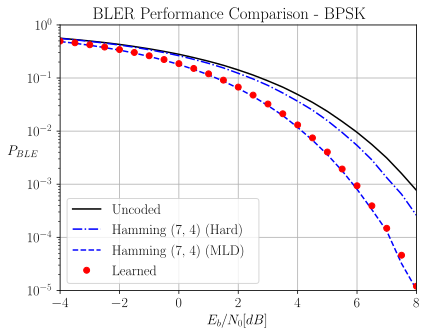

In [12]:
plt.rcParams.update({
    "text.usetex": True, # Comment this if TeX is not available in your machine
    "font.family" : 'serif',
    "font.size": 12
})

fig, axes = plt.subplots()
axes.semilogy(SNR_dB, BLER_uncoded, label="Uncoded", c='black')
axes.semilogy(SNR_dB, BLER_coded_hard, label="Hamming (7, 4) (Hard)", c="blue", ls="-.")
axes.semilogy(SNR_dB, BLER_coded_MLD, label="Hamming (7, 4) (MLD)", c="blue", ls="--")
axes.semilogy(SNR_dB, BLER_learned, label="Learned", c='red', marker='o', ls=" ")
axes.set_xlabel(r'$E_b / N_0[dB]$')
axes.set_ylabel(r'$P_{BLE}$', rotation=0)
axes.set_xlim(-4, 8)
axes.set_ylim(10**-5, 10**0)
axes.set_title(f'BLER Performance Comparison - BPSK')
axes.legend()
axes.grid()

In [13]:
# Saving the results for future reference
fig.savefig(fname='plots/deepComms_7_4.svg', transparent=True)
with open("results/results_deepComms_7_4.txt", mode='w') as file_id :
    file_id.write("BLER_uncoded = ")
    file_id.write(f'{str(BLER_uncoded)}\n')
    file_id.write("BLER_coded_hard = ")
    file_id.write(f'{str(BLER_coded_hard)}\n')
    file_id.write("BLER_coded_MLD = ")
    file_id.write(f'{str(BLER_coded_MLD)}\n')
    file_id.write("BLER_learned = ")
    file_id.write(str(BLER_learned))

> Using this same model for performing manual coherent detection :

- Here we take the output from encoder of the above learned system, then we simulate the fading and noise by ourselves. After that we do coherent detection. Then, the resultant signal is passed on to the decoder of the above learned system. 

In [14]:
BLER_manual_coherent = []
for noise in noise_var :
    # Encoding using our model :
    encoded_signal = encoder_model.predict(x_test)
    # Fast fading effect :
    fade_taps = np.random.normal(0, np.sqrt(0.5), (test_data_size, n)) + 1j* np.random.normal(0, np.sqrt(0.5), (test_data_size, n))
    rx_faded_signal = fade_taps * encoded_signal
    # Generating AWGN samples :
    awgn = np.random.normal(0, np.sqrt(noise), (test_data_size, n)) + 1j* np.random.normal(0, np.sqrt(noise), (test_data_size, n))
    rx_noisy_signal = rx_faded_signal + awgn 
    # Decoding using our model :
    decoded_signal = decoder_model.predict(np.real(np.conjugate(fade_taps) * rx_noisy_signal / np.absolute(fade_taps)))
    estimated_vectors = np.argmax(decoded_signal, axis=-1)
    BLER_manual_coherent.append(np.sum(estimated_vectors != y_test) / test_data_size)

31250/31250 ━━━━━━━━━━━━━━━━━━━━ 26s 825us/step
31250/31250 ━━━━━━━━━━━━━━━━━━━━ 27s 878us/step
31250/31250 ━━━━━━━━━━━━━━━━━━━━ 27s 857us/step
31250/31250 ━━━━━━━━━━━━━━━━━━━━ 27s 866us/step
31250/31250 ━━━━━━━━━━━━━━━━━━━━ 26s 821us/step
31250/31250 ━━━━━━━━━━━━━━━━━━━━ 27s 848us/step
31250/31250 ━━━━━━━━━━━━━━━━━━━━ 46s 1ms/step
31250/31250 ━━━━━━━━━━━━━━━━━━━━ 40s 1ms/step
31250/31250 ━━━━━━━━━━━━━━━━━━━━ 25s 792us/step
31250/31250 ━━━━━━━━━━━━━━━━━━━━ 28s 886us/step
31250/31250 ━━━━━━━━━━━━━━━━━━━━ 28s 893us/step
31250/31250 ━━━━━━━━━━━━━━━━━━━━ 26s 837us/step
31250/31250 ━━━━━━━━━━━━━━━━━━━━ 23s 750us/step
31250/31250 ━━━━━━━━━━━━━━━━━━━━ 35s 1ms/step
31250/31250 ━━━━━━━━━━━━━━━━━━━━ 51s 2ms/step
31250/31250 ━━━━━━━━━━━━━━━━━━━━ 26s 835us/step
31250/31250 ━━━━━━━━━━━━━━━━━━━━ 56s 2ms/step
31250/31250 ━━━━━━━━━━━━━━━━━━━━ 66s 2ms/step
31250/31250 ━━━━━━━━━━━━━━━━━━━━ 54s 2ms/step
31250/31250 ━━━━━━━━━━━━━━━━━━━━ 62s 2ms/step
31250/31250 ━━━━━━━━━━━━━━━━━━━━ 55s 2ms/step
31250/3125

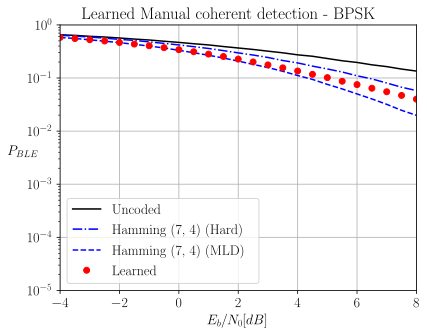

In [15]:
# Comparison curves : These have been obtained by classical method simulations
BLER_uncoded_coherent = [0.65215, 0.63525, 0.60991, 0.59174, 0.56693, 0.54118, 0.51972, 0.49274, 0.46816, 0.44209, 0.4198, 0.39144, 0.36744, 0.34496, 0.32022, 0.29818, 0.27314, 0.2568, 0.23292, 0.21127, 0.1964, 0.17721, 0.16392, 0.14737, 0.13511]
BLER_coded_coherent_MLD = [0.58016, 0.55535, 0.52368, 0.49402, 0.46342, 0.43045, 0.39986, 0.36771, 0.33257, 0.29946, 0.26815, 0.23793, 0.20806, 0.18062, 0.15724, 0.13379, 0.11153, 0.09413, 0.07586, 0.0623, 0.05014, 0.04037, 0.03194, 0.02463, 0.01983]
BLER_coded_coherent_Hard = [0.6366, 0.61527, 0.58994, 0.56438, 0.53288, 0.5114, 0.47843, 0.44857, 0.41948, 0.38905, 0.35984, 0.32792, 0.29742, 0.27081, 0.24346, 0.21354, 0.19237, 0.16746, 0.14807, 0.12968, 0.11011, 0.09618, 0.08048, 0.06702, 0.05804]
# Plotting :
fig, axes = plt.subplots()
axes.semilogy(SNR_dB, BLER_uncoded_coherent, label="Uncoded", c='black')
axes.semilogy(SNR_dB, BLER_coded_coherent_Hard, label="Hamming (7, 4) (Hard)", c="blue", ls="-.")
axes.semilogy(SNR_dB, BLER_coded_coherent_MLD, label="Hamming (7, 4) (MLD)", c="blue", ls="--")
axes.semilogy(SNR_dB, BLER_manual_coherent, label="Learned", c='red', marker='o', ls=" ")
axes.set_xlabel(r'$E_b / N_0[dB]$')
axes.set_ylabel(r'$P_{BLE}$', rotation=0)
axes.set_xlim(-4, 8)
axes.set_ylim(10**-5, 10**0)
axes.set_title(f'Learned Manual coherent detection - BPSK')
axes.legend()
axes.grid()

In [16]:
# Saving the results for future reference
# Plots :
fig.savefig(fname='plots/deepComms_7_4_manual_coherent.svg', transparent=True)
# Values :
with open("results/results_deepComms_7_4_manual_coherent.txt", mode='w') as file_id :
    file_id.write("BLER_uncoded_coherent = ")
    file_id.write(f'{str(BLER_uncoded_coherent)}\n')
    file_id.write("BLER_coded_coherent_hard = ")
    file_id.write(f'{str(BLER_coded_coherent_Hard)}\n')
    file_id.write("BLER_coded_coherent_MLD = ")
    file_id.write(f'{str(BLER_coded_coherent_MLD)}\n')
    file_id.write("BLER_manual_coherent = ")
    file_id.write(str(BLER_manual_coherent))